In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def manhattan(x1: int, y1: int, x2: int, y2: int) -> int:
    return abs(x1 - x2) + abs(y1 - y2)

def lr_proba(dist, alpha):
    if not isinstance(dist, np.ndarray):
        dist = np.array(dist, dtype=float)
    
    zero_mask = dist <= 1
    result = np.zeros_like(dist)
    result[~zero_mask] = dist[~zero_mask] ** -alpha
    return result

Text(0, 0.5, 'Probability')

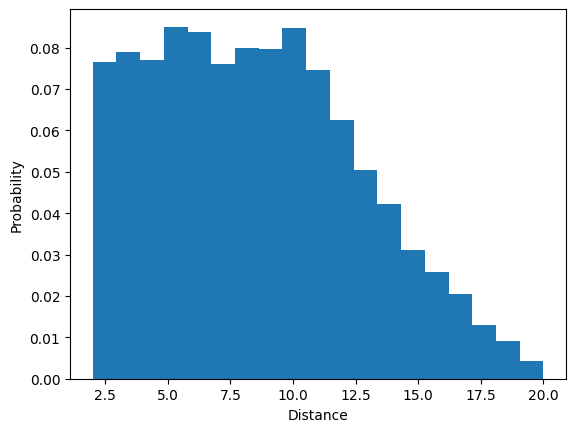

In [48]:
class ReferenceDistanceSampler:
    def __init__(self, n: int, alpha: float):
        self.n = n
        self.alpha = alpha
        proba_mtx = np.zeros((n*2+1, n*2+1))
        for i in range(n*2+1):
            for j in range(n*2+1):
                dist = manhattan(n, n, i, j)
                proba_mtx[i, j] = lr_proba(dist, alpha)
        proba_mtx /= proba_mtx.sum()
        self.probas = proba_mtx.flatten()
        self.index = np.arange(len(self.probas))

    def sample(self, num_samples: int = 1):
        indices = np.random.choice(self.index, p=self.probas, size=num_samples)
        x, y = np.unravel_index(indices, (self.n*2+1, self.n*2+1))
        x -= self.n
        y -= self.n
        return np.abs(x) + np.abs(y)



s = ReferenceDistanceSampler(10, 1)
samples = s.sample(10000)
plt.hist(samples, bins=len(set(samples)), density=True)
plt.xlabel('Distance')
plt.ylabel('Probability')